In [3]:
### import libraries ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors

In [4]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 20})
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

/tmp/ipykernel_21531/534975185.py:5: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


In [51]:
### Define parameters ###
# [Z] is the metallicity of the stars                               e.g. '02' for Z=0.02 solar metallicity

Z = '002'
path_output = f'./HRdiagram/Z{Z}/sevn_output/'  # path to new folder with all useful results


# extract the output file
out = pd.read_csv(f'{path_output}/output_0.csv')
names = out.name.drop_duplicates().values

In [6]:
# isoradii from L=4PIR**2T**4 --> R=np.sqrt(L/(4piT**4))
Rsun=7e10 # solar radius in cm
Tsun=5772  # solar temperature kelvin
sigmaBoltz=5.670374e-5 # erg⋅cm^-2⋅s^-1⋅K^-4
Lsun=4*np.pi*Rsun*Rsun*sigmaBoltz*Tsun**4   # solar tluminosity erg/s

def LfromR(Radius,Teff):   # Radius in solar units, Teff in kelvin
    R=Radius*Rsun   # convert into cm
    Lerg = 4*np.pi*R*R*sigmaBoltz*Teff**4   # returns L in ergs
    return Lerg/Lsun  #returns L in solar units

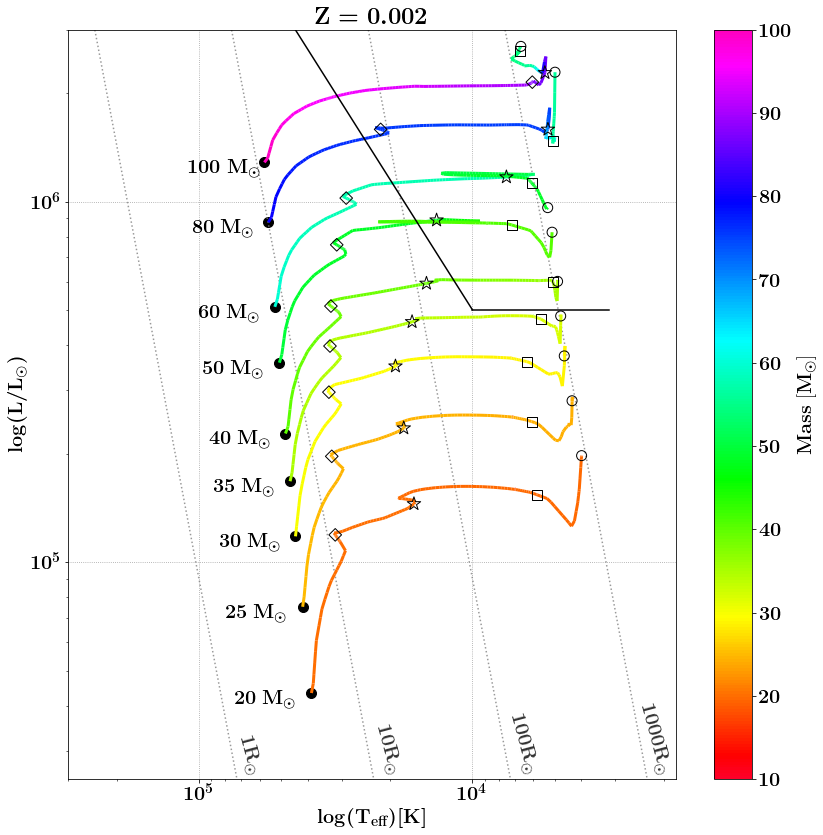

In [52]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
ax.set_title(fr'$\rm Z=0.{Z}$')
for name in names:
    singlestar = out[out.name == name] # select single binary
    singlepreSN = singlestar.loc[singlestar.Phase != 7]  # remove remnants 
    Mdot =  singlepreSN.Mass.values[:-1] - singlepreSN.Mass.values[1:]  # initial - final since initial > final
    Mass = singlepreSN.Mass.values
    
    
    # extract significative burnings
    ZAMS = singlepreSN.iloc[:1]   # start of H shell burning
    preSN = singlepreSN.iloc[-1:]   # start of H shell burning
    #HGstart = singlepreSN.loc[singlepreSN.Phase == 2].iloc[:1]   # terminal MS (HG/GB)
    Hshell = singlepreSN.loc[singlepreSN.Phase == 3].iloc[:1]   # start of H shell burning (Giant Branch)
    coreHE = singlepreSN.loc[singlepreSN.PhaseBSE == 4].iloc[:1]   # start of core He burning
    WR = singlepreSN.loc[singlepreSN.PhaseBSE == 7].iloc[:1]   # start of WR phase
    terminalHE = singlepreSN.loc[singlepreSN.Phase == 5].iloc[:1]   # start of core He burning
    WRterminalHE = singlepreSN.loc[(singlepreSN.PhaseBSE == 8) & (singlepreSN.Phase == 5)].iloc[:1]   # WR at start of core He burning
    HEshell = singlepreSN.loc[singlepreSN.Phase == 6].iloc[:1]   # start of He shell burning
    WRHEshell = singlepreSN.loc[(singlepreSN.PhaseBSE == 8) & (singlepreSN.Phase == 6)].iloc[:1] # WR at start of HE shell burning
    

    
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    x,y = singlepreSN.Temperature.values,singlepreSN.Luminosity.values
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = colors.Normalize(10,100)
    lc = LineCollection(segments, cmap='gist_rainbow', norm=norm)
    # Set the values used for colormapping
    lc.set_array(Mass)
    lc.set_linewidth(3)
    line = ax.add_collection(lc)    
    
    # plot significative burnings
    plt.scatter(ZAMS.Temperature.values,ZAMS.Luminosity.values,s=100, marker='o', c='k')
    mass0 = round(Mass[0])
    if mass0 == 99:
        mass0=100
    ax.annotate(fr'$\textbf{mass0}$'+ r' $\rm M_\odot$', (x[0]+x[0]/1.1,y[0]-y[0]/15),color='k')
    plt.scatter(Hshell.Temperature.values,Hshell.Luminosity.values, s=80, marker='D', ec='k', fc='None',zorder=30)
    #plt.scatter(HGstart.Temperature.values,HGstart.Luminosity.values, s=100, marker='s', c='fuchsia')
    plt.scatter(coreHE.Temperature.values,coreHE.Luminosity.values, s=200, marker='*', ec='k',fc='None',zorder=30)
    plt.scatter(WR.Temperature.values,WR.Luminosity.values, s=200, marker='*',c='k',zorder=100)
    #plt.scatter(terminalHE.Temperature.values,terminalHE.Luminosity.values, s=50, marker='o', c='dodgerblue')
    plt.scatter(HEshell.Temperature.values,HEshell.Luminosity.values, s=100, marker='s', ec='k',fc='None',zorder=30)
    #plt.scatter(WRterminalHE.Temperature.values,WRterminalHE.Luminosity.values, s=50, marker='s',c='k', zorder=30)
    plt.scatter(preSN.Temperature.values,preSN.Luminosity.values,s=100, marker='o', ec='k',fc='None',zorder=30)
    plt.scatter(WRHEshell.Temperature.values,WRHEshell.Luminosity.values, s=100, marker='s',c='k',zorder=100)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3e5,1.8e3)
ax.set_ylim(2.5e4,3e6)
ax.grid(linestyle='dotted',alpha=0.8,c='grey')

    
# plot isoradii
Temp = np.linspace(1e3,1e6,10) # effective temperatures in Kelvin
plt.plot(Temp,LfromR(1,Temp),color='grey',linestyle='dotted',alpha=0.8,zorder=1) 
plt.plot(Temp,LfromR(10,Temp),color='grey',linestyle='dotted',alpha=0.8,zorder=1) 
plt.plot(Temp,LfromR(100,Temp),color='grey',linestyle='dotted',alpha=0.8,zorder=1) 
plt.plot(Temp,LfromR(1000,Temp),color='grey',linestyle='dotted',alpha=0.8,zorder=1) 
ax.annotate(r'$1 \rm R_\odot$',xy=(7.3e4,2.6e4),rotation=-75,color='k',alpha=0.8)
ax.annotate(r'$10 \rm R_\odot$',xy=(2.3e4,2.6e4),rotation=-75,color='k',alpha=0.8)
ax.annotate(r'$100 \rm R_\odot$',xy=(7.5e3,2.6e4),rotation=-75,color='k',alpha=0.8)
ax.annotate(r'$1000 \rm R_\odot$',xy=(2.5e3,2.6e4),rotation=-75,color='k',alpha=0.8)


# plot Humphreys–Davidson limit from chen2015 
ax.plot([10**(3.5),1e4],[10**(5.7),10**(5.7)],color='k')
ax.plot([1e4,1e5],[10**(5.7),10**(6.9)],color='k')



ax.set_xlabel(r'$\log(\rm T_{\rm eff}) \textbf{[K]}$')
ax.set_ylabel(r'$\log(\rm L/L_\odot)$')
    

fig.colorbar(line, ax=ax,label=r'$\textbf{Mass}$ [$\rm M_\odot$]')
plt.tight_layout()
plt.show()
fig.savefig(f'./HRdiagram/Z{Z}/HR_{Z}.pdf')

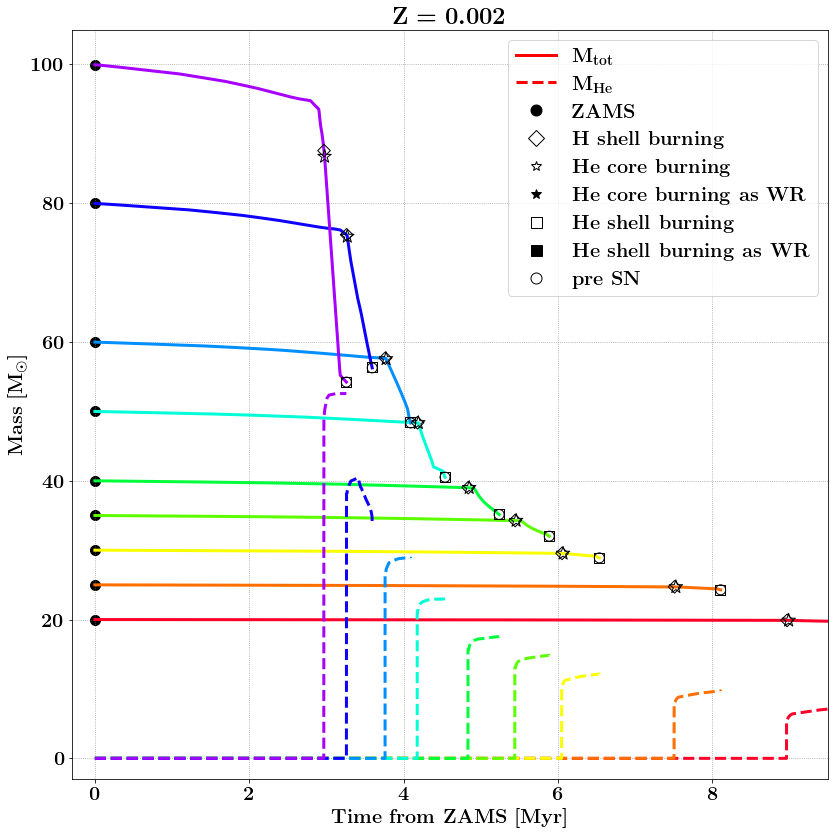

In [53]:
# colors
NUM_COLORS = len(names)
cm = plt.get_cmap('gist_rainbow')
colorlist=[]
for i in range(NUM_COLORS):
    colorlist.append(cm(1.*i/NUM_COLORS))  # color will now be an RGBA tuple


fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
ax.set_title(fr'$\rm Z=0.{Z}$')
for c, name in zip(colorlist,names):
    singlestar = out[out.name == name] # select single binary
    singlepreSN = singlestar.loc[singlestar.Phase != 7]  # remove remnants 
    
    
    # extract significative burnings
    ZAMS = singlepreSN.iloc[:1]   # start of H shell burning
    preSN = singlepreSN.iloc[-1:]   # start of H shell burning
    #HGstart = singlepreSN.loc[singlepreSN.Phase == 2].iloc[:1]   # terminal MS (HG/GB)
    Hshell = singlepreSN.loc[singlepreSN.Phase == 3].iloc[:1]   # start of H shell burning (Giant Branch)
    coreHE = singlepreSN.loc[singlepreSN.PhaseBSE == 4].iloc[:1]   # start of core He burning
    WR = singlepreSN.loc[singlepreSN.PhaseBSE == 7].iloc[:1]   # start of WR phase
    terminalHE = singlepreSN.loc[singlepreSN.Phase == 5].iloc[:1]   # start of core He burning
    WRterminalHE = singlepreSN.loc[(singlepreSN.PhaseBSE == 8) & (singlepreSN.Phase == 5)].iloc[:1]   # WR at start of core He burning
    HEshell = singlepreSN.loc[singlepreSN.Phase == 6].iloc[:1]   # start of He shell burning
    WRHEshell = singlepreSN.loc[(singlepreSN.PhaseBSE == 8) & (singlepreSN.Phase == 6)].iloc[:1] # WR at start of HE shell burning

     # plot significative burnings
    plt.scatter(ZAMS.Worldtime.values,ZAMS.Mass.values,s=100, marker='o', c='k')
    plt.scatter(Hshell.Worldtime.values,Hshell.Mass.values, s=80, marker='D', ec='k', fc='None',zorder=30)
    #plt.scatter(HGstart.Worldtime.values,HGstart.Mass.values, s=100, marker='s', c='fuchsia')
    plt.scatter(coreHE.Worldtime.values,coreHE.Mass.values, s=200, marker='*', ec='k',fc='None',zorder=30)
    plt.scatter(WR.Worldtime.values,WR.Mass, s=200, marker='*',c='k',zorder=100)
    #plt.scatter(terminalHE.Temperature.values,terminalHE.Luminosity.values, s=50, marker='o', c='dodgerblue')
    plt.scatter(HEshell.Worldtime.values,HEshell.Mass.values, s=100, marker='s', ec='k',fc='None',zorder=30)
    #plt.scatter(WRterminalHE.Temperature.values,WRterminalHE.Luminosity.values, s=50, marker='s',c='k', zorder=30)
    plt.scatter(preSN.Worldtime.values,preSN.Mass.values,s=100, marker='o', ec='k',fc='None',zorder=30)
    plt.scatter(WRHEshell.Worldtime.values,WRHEshell.Mass.values, s=100, marker='s',c='k',zorder=100)
    
    ax.plot(singlepreSN.Worldtime.values,singlepreSN.Mass.values,color=c,linewidth=3)
    ax.plot(singlepreSN.Worldtime.values,singlepreSN.MHE.values,color=c,linestyle='dashed',linewidth=3)
    
    
    
# legend
l1, = ax.plot([-1], [-1.5], linestyle='solid', lw=3, color='r')
l2, = ax.plot([-1], [-1.5], linestyle='dashed', lw=3, color='r')
m1, = ax.plot([-1], [-1], 'o', mfc="k", mec='k',ms=11)
m2, = ax.plot([-1], [-1], 'D', mfc="None", mec='k',ms=11)
m3, = ax.plot([-1], [-1], '*', mfc="None", mec='k',ms=11)
m4, = ax.plot([-1], [-1], '*', mfc="k", mec='k',ms=11)
m5, = ax.plot([-1], [-1], 's', mfc="None", mec='k',ms=11)
m6, = ax.plot([-1], [-1], 's', mfc="k", mec='k',ms=11)
m7, = ax.plot([-1], [-1], 'o', mfc="None", mec='k',ms=11)

ax.legend([l1,l2,m1,m2,m3,m4,m5,m6,m7], [r'$\rm M_{\rm tot}$',r'$\rm M_{\rm He}$',r'$\rm ZAMS$',
                                        r'\textbf{H shell burning}',r'\textbf{He core burning}', r'\textbf{He core burning as WR}',
                                        r'\textbf{He shell burning}', r'\textbf{He shell burning as WR}',r'\textbf{pre SN}'],loc = 'upper right',)

ax.grid(linestyle='dotted',alpha=0.8,c='grey')
ax.set_xlabel(r'\textbf{Time from ZAMS [Myr]}')
ax.set_ylabel(r'$\rm Mass~[M_\odot]$')
ax.set_xlim(-0.3,9.5)
ax.set_ylim(-3,105)

plt.tight_layout()
plt.show()
fig.savefig(f'./HRdiagram/Z{Z}/mass_Z{Z}.pdf')